In [1]:
import numpy as np  
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import KFold
import tensorflow as tf
#Function import
from ipynb.fs.full.autoXRD import normdata
from ipynb.fs.full.autoXRD import normdatasingle
from ipynb.fs.full.autoXRD import augdata
from ipynb.fs.full.autoXRD import exp_augdata
from ipynb.fs.full.autoXRD import exp_data_processing

In [2]:
#Import simulated XRD
theor = pd.read_csv('Datasets/theor.csv', index_col=0)
print(theor.shape)
theor = theor.iloc[1:,]
theor_arr = theor.values
print(theor_arr.shape)

# Normalize data for training
ntheor = normdata(theor_arr)
print(ntheor.shape)

#exp = pd.read_csv('Datasets/exp.csv', index_col=0)
#exp_arr = exp.values
#print(exp_arr.shape)

(2402, 1468)
(2401, 1468)
(2401, 734)


In [3]:
#Import dimensionalities
label_theo = pd.read_csv('Datasets/label_theo_dataaug.csv', header=None, index_col=0)
label_theo = label_theo[1].tolist()

# Load experimental class labels
#label_exp= pd.read_csv('Datasets/label_theo.csv', index_col=0).values
#label_exp = label_exp.reshape([len(label_exp),])

space_group_enc = pd.read_csv('Datasets/encoding.csv', index_col=0)
space_group_enc = list(space_group_enc['0'])

print(len(label_theo))
print(ntheor.shape)

1468
(2401, 734)


In [4]:
#augdata(data,num,par1,minn,maxn)
# Specify how many data points we augmented
th_num = 10000

# Define 2theta range for data augmentation
exp_min = 0
exp_max = 2200
theor_min = 125
theor_max = theor_min+exp_max-exp_min

# Perform data augmentation
augd, pard, crop_augd = augdata(ntheor, th_num, label_theo, theor_min, theor_max) 

# Enconde theoretical labels
label_t = np.zeros([len(pard),])
for i in range(len(pard)):
    label_t[i] = space_group_enc.index(pard[i])

print(augd.shape)
print(crop_augd.shape)
print(label_t.shape)

(2401, 10000)
(2200, 10000)
(10000,)


In [5]:
#prepare X et Y
X_th = np.transpose(crop_augd)
#X_th = X_th.reshape(734, 2401, 1)
X_th = X_th.reshape(th_num, exp_max-exp_min, 1)
Y_th = label_t

X_th = X_th.astype(np.float32)
Y_th = Y_th.astype(np.float32)

print(X_th.shape)
print(Y_th.shape)

(10000, 2200, 1)
(10000,)


In [6]:
# Introduction de set de test à partir de la base de données
# Definition du set de test 20% d'images random
# Avec cette ligne on definit set de images et targets pour l'entrainement et test
X_th_train, X_th_valid, Y_th_train, Y_th_valid = train_test_split(X_th, Y_th, test_size=0.2, random_state=1)

print("X_th_train", X_th_train.shape)
print("X_th_valid", X_th_valid.shape)

print("Y_th_train", Y_th_train.shape)
print("Y_th_valid", Y_th_valid.shape)

train_dataset = tf.data.Dataset.from_tensor_slices((X_th, Y_th))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_th_valid, Y_th_valid))

print(train_dataset)
print(valid_dataset)

X_th_train (8000, 2200, 1)
X_th_valid (2000, 2200, 1)
Y_th_train (8000,)
Y_th_valid (2000,)
<TensorSliceDataset shapes: ((2200, 1), ()), types: (tf.float32, tf.float32)>
<TensorSliceDataset shapes: ((2200, 1), ()), types: (tf.float32, tf.float32)>


In [7]:
# Iter in the dataset with a number of epoch and batch size
epoch = 1
batch_size = 32
for X_th_batch, Y_th_batch in train_dataset.repeat(epoch).batch(batch_size):
    print(X_th_batch.shape, Y_th_batch.shape)
    break

(32, 2200, 1) (32,)


In [8]:
class ConvModel(tf.keras.Model):
    
    def __init__(self):
        super(ConvModel, self).__init__()
        # Convolutions
        self.conv1 = tf.keras.layers.Conv1D(32, 8, padding='same', activation='relu', name="conv1")
        self.conv2 = tf.keras.layers.Conv1D(64, 5, padding='same',activation='relu', name="conv2")
        self.conv3 = tf.keras.layers.Conv1D(128, 3, padding='same',activation='relu', name="conv3")
        # Flatten the convolution
        self.flatten = tf.keras.layers.Flatten(name="flatten")       
        # Dense layers
        self.d1 = tf.keras.layers.Dense(128, activation='relu', name="d1")
        self.out = tf.keras.layers.Dense(4, activation='softmax', name="output")

    def call(self, X_th):
        conv1 = self.conv1(X_th)
        #print(conv1)
        conv2 = self.conv2(conv1)
        #print(conv2)
        conv3 = self.conv3(conv2)
        #print(conv3)
        flatten = self.flatten(conv3)
        #print(flatten)
        d1 = self.d1(flatten)
        #print(d1)
        output = self.out(d1)
        return output

model = ConvModel()
#model.predict(X_th[:,:,:])

In [9]:
#Define loss, optimizer, accuracy for th emodel to compile
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# Loss
train_loss = tf.keras.metrics.Mean(name='train_loss')
valid_loss = tf.keras.metrics.Mean(name='valid_loss')
# Accuracy
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='valid_accuracy')

In [10]:
# Definition de la fonction qui va entrainer le modele
# On utilise un graphe @
@tf.function
def train_step(X_th, Y_th):
    # Calcul du gradient
    with tf.GradientTape() as tape:
        # Make a prediction on all the batch
        predictions = model(X_th)
        # Get the error/loss on these predictions
        loss = loss_object(Y_th, predictions)
    # Compute the gradient which respect to the loss
    gradients = tape.gradient(loss, model.trainable_variables)
    # Change the weights of the model
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    # The metrics are accumulate over time. You don't need to average it yourself.
    train_loss(loss)
    train_accuracy(Y_th, predictions)

In [11]:
# Methode de validation en mode graphe
@tf.function
def valid_step(X_th, Y_th):
    predictions = model(X_th)
    t_loss = loss_object(Y_th, predictions)
    # Set the metrics for the test
    valid_loss(t_loss)
    valid_accuracy(Y_th, predictions)

In [12]:
#Iteration du modele
epoch = 5
batch_size = 256
b = 0 #Compter les batchs
for epoch in range(epoch):
    # Training set
    for X_th_batch, Y_th_batch in train_dataset.batch(batch_size): #Iteration dans la dataset
        train_step(X_th_batch, Y_th_batch) #On lance un entrainement
        template = '\r Batch {}/{}, Loss: {}, Accuracy: {}'
        print(template.format(
            b, len(Y_th), train_loss.result(), 
            train_accuracy.result()*100
        ), end="") #Informations de l'entrainement
        b += batch_size
    # Validation set
    for X_th_batch, Y_th_batch in valid_dataset.batch(batch_size):
        valid_step(X_th_batch, Y_th_batch) #Mesure precision sur chacun des batch

    template = '\nEpoch {}, Valid Loss: {}, Valid Accuracy: {}'
    print(template.format(
        epoch+1,
        valid_loss.result(), 
        valid_accuracy.result()*100)
    )
    #A la fin de chaque epoch on vide
    valid_loss.reset_states()
    valid_accuracy.reset_states()
    train_accuracy.reset_states()
    train_loss.reset_states()

 Batch 9984/10000, Loss: 0.7778769135475159, Accuracy: 71.100006103515625
Epoch 1, Valid Loss: 0.6081068515777588, Valid Accuracy: 77.94999694824219
 Batch 20224/10000, Loss: 0.4822959899902344, Accuracy: 82.650001525878956
Epoch 2, Valid Loss: 0.41984251141548157, Valid Accuracy: 83.95000457763672
 Batch 30464/10000, Loss: 0.3099782168865204, Accuracy: 88.510002136230479
Epoch 3, Valid Loss: 0.25603267550468445, Valid Accuracy: 90.9000015258789
 Batch 40704/10000, Loss: 0.17647597193717957, Accuracy: 93.68000030517578
Epoch 4, Valid Loss: 0.23258742690086365, Valid Accuracy: 91.44999694824219
 Batch 50944/10000, Loss: 0.14531664550304413, Accuracy: 94.63999938964844
Epoch 5, Valid Loss: 0.07388471066951752, Valid Accuracy: 97.8499984741211


In [13]:
res = model.predict(X_th[:,:,:])
print(res.shape)
for i in range(723, 733):
    print(res[i], label_theo[i])

(10000, 4)
[2.5737043e-07 1.1763933e-02 9.8818296e-01 5.2932519e-05] 1D
[1.0994974e-03 6.5399897e-03 9.9221969e-01 1.4083252e-04] 1D
[1.4223656e-01 7.7339423e-01 8.4369309e-02 6.0803353e-09] 1D
[6.3726323e-04 9.9929559e-01 5.8867081e-05 8.1921162e-06] 1D
[4.0594055e-03 7.1575695e-01 2.8018326e-01 3.3489789e-07] 1D
[0.0010732  0.00121203 0.9865226  0.01119209] 0D
[2.8437287e-07 9.9992883e-01 4.8611946e-05 2.2281571e-05] 0D
[2.4788125e-04 9.8313880e-01 1.6613362e-02 2.7711650e-10] 2D
[2.3814088e-07 9.9997234e-01 2.7372391e-05 8.6617782e-21] 2D
[1.3959138e-10 3.6105741e-06 9.9999535e-01 1.0551905e-06] 2D


(4305, 136)


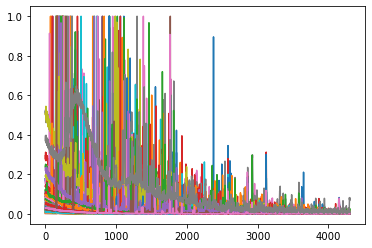

(4305, 68)


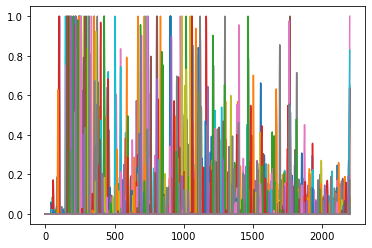

(2200, 68)


In [16]:
#Load experimental data as dataframe
exp = pd.read_csv('Datasets/exp.csv', index_col=0)
exp_arr = exp.values
print(exp_arr.shape)

#Normalisation
nexp = normdata(exp_arr)
plt.plot(nexp)
plt.show()
print(nexp.shape)

# Process data experimental
# Define spectral range for data augmentation
exp_min = 0
exp_max = 2200 
theor_min = 125

#window size for experimental data extraction
window = 10
theor_max = theor_min+exp_max-exp_min

# Preprocess experimental data
post_exp = normdatasingle(exp_data_processing(nexp, exp_min, exp_max, window))
plt.plot(post_exp)
plt.show()

print(post_exp.shape)

# Specify how many data points we augmented
#th_num = 734

# Augment data, this may take a bit
#augd,pard,crop_augd = augdata(ntheor, th_num, label_theo, theor_min, theor_max)
# Input the num of experimetal data points       
exp_num = 68
#prepare arrays
X_exp = np.transpose(post_exp)
X_exp = X_exp.reshape(exp_num, exp_max-exp_min, 1)

X_exp = X_exp.astype(np.float32)

In [17]:
model.predict(X_exp[:,:,:])

array([[2.44026022e-09, 3.86104046e-04, 9.99611318e-01, 2.59482499e-06],
       [9.88122650e-08, 6.70370040e-03, 9.93296206e-01, 4.00347169e-08],
       [8.45059276e-07, 8.14599991e-01, 1.85399175e-01, 3.27215033e-10],
       [1.74989850e-07, 2.77297795e-01, 7.22699463e-01, 2.61104492e-06],
       [3.88345186e-04, 1.34467050e-01, 8.65144610e-01, 2.47924511e-11],
       [5.02122493e-05, 9.99516010e-01, 4.33882029e-04, 5.64096617e-11],
       [3.36613567e-16, 3.77976426e-12, 5.34304269e-02, 9.46569502e-01],
       [8.43159141e-05, 8.40289474e-01, 1.08599558e-01, 5.10266200e-02],
       [6.07614122e-17, 6.29897870e-11, 1.00000000e+00, 3.84342974e-11],
       [1.44651890e-09, 9.62221861e-01, 3.77781726e-02, 6.32025376e-10],
       [3.80462996e-04, 1.78497553e-01, 4.81636636e-02, 7.72958279e-01],
       [1.13991369e-02, 1.70879116e-06, 9.88599181e-01, 1.27833888e-09],
       [1.42457880e-14, 9.99999523e-01, 5.03334547e-07, 1.06630867e-11],
       [1.76422266e-09, 3.38680227e-04, 9.99649167e